In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py

2022-07-18 12:06:47.845720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 12:06:47.845740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-18 12:06:49.525180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-18 12:06:49.525215: W tensorflow/

In [2]:
f3 = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
f2 = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
f= h5py.File("../../data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")

In [3]:
x_train = f.get('X_jets')

In [4]:
y_train = f.get('y')

In [5]:
x_train[0:3].shape

(3, 125, 125, 3)

In [6]:
np.sum(x_train[0:3],axis=(1,2)).shape

(3, 3)

In [7]:
#x_train[0:3]/np.sum(x_train[0:3],axis=(1,2)).reshape((3,1,1,3))

In [8]:
x_val = f2.get('X')
y_val = f2.get('y')

In [9]:
import keras
import numpy as np
from tensorflow.keras.utils import Sequence

In [10]:
x_train.shape[0]

139306

In [11]:
batch_size = 500
num_batches = x_train.shape[0]//batch_size

In [12]:
num_batches

278

In [13]:
#maxx = 0
#minn = 10000000

#for i in range(int(num_batches)):
#    y = y_train[i * batch_size: (i + 1) * batch_size]
#    cmax = np.max(np.log(x_train[i * batch_size: (i + 1) * batch_size][y==0] + 1))
#    if cmax > maxx:
#        maxx = cmax
#    cmin = np.min(np.log(x_train[i * batch_size: (i + 1) * batch_size][y==0] + 1) )
#    if cmin < minn:
#        minn = cmin
#    print(i, end="\r")
#    
#print(maxx)
#print(minn)

In [14]:
from sklearn.preprocessing import normalize

class Generator(Sequence) :
  
  def __init__(self, hdf5_file, y_hdf5_file, batch_size, y_train_selection, num_batches_to_train) :
    self.hdf5_file = hdf5_file
    self.batch_size = batch_size
    self.y_train_selection = y_train_selection
    self.y_hdf5_file = y_hdf5_file
    self.num_batches_to_train = num_batches_to_train
    
  # Länge der Trainingsdaten (Anzahl der Batches)
  def __len__(self) :
    #return x_train.shape[0]//self.batch_size
    return self.num_batches_to_train
  
  # Lädt Bilder anhand der Pfade aus dem Trainingsarray
#  def __getitem__(self, idx) :
#    y = self.y_hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size]
#    return self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size][y==self.y_train_selection], self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size][y==self.y_train_selection]
  def __getitem__(self, idx) :
    y = self.y_hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size]
    x = self.hdf5_file[idx * self.batch_size: (idx + 1) * self.batch_size][y==self.y_train_selection]
    divide = np.sum(x, axis=(1,2)).reshape((x.shape[0],1,1,3))
    divide[divide == 0] = 1
    return (x/divide).reshape((x.shape[0],125*125*3)), (x/divide).reshape((x.shape[0],125*125*3))

In [15]:
num_batches_to_train = 100
traingen = Generator(x_train, y_train, 500, 0, num_batches_to_train)

In [16]:
model = cae.Autoencoder(125*125*3,256)

In [17]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               12000256  
                                                                 
Total params: 12,000,256
Trainable params: 12,000,256
Non-trainable params: 0
_________________________________________________________________


In [18]:
#model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001))

/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
x_val_zeros = x_val[y_val[()]==0]
divide = np.sum(x_val_zeros, axis=(1,2)).reshape(x_val_zeros.shape[0],1,1,3)
divide[divide == 0] = 1
x_val_zeros = x_val_zeros/divide

In [20]:
(y_val[()]==0).shape

(10000,)

In [21]:
x_val.shape

(10000, 125, 125, 3)

In [22]:
x_val_zeros.shape

(5000, 125, 125, 3)

In [23]:
x_val_zeros = x_val_zeros.reshape((x_val_zeros.shape[0],125*125*3))

In [24]:
x_val_zeros.shape

(5000, 46875)

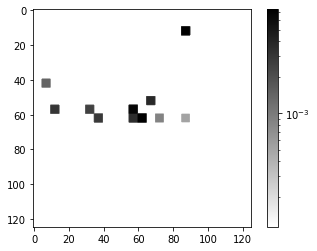

In [25]:
from matplotlib.colors import LogNorm
plt.imshow(x_val_zeros.reshape((x_val_zeros.shape[0],125,125,3))[4,:,:,2],cmap='binary', norm=LogNorm())
plt.colorbar()

In [26]:
hist = model.fit_generator(traingen,epochs=3,validation_data=(x_val_zeros,x_val_zeros))

/tmp/ipykernel_585443/3640696743.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(traingen,epochs=3,validation_data=(x_val_zeros,x_val_zeros))


Epoch 1/3
100/100 [==============================] - 268s 3s/step - loss: 0.6904 - val_loss: 0.6858
Epoch 2/3
100/100 [==============================] - 289s 3s/step - loss: 0.6633 - val_loss: 0.6211
Epoch 3/3
100/100 [==============================] - 240s 2s/step - loss: 0.5373 - val_loss: 0.4378


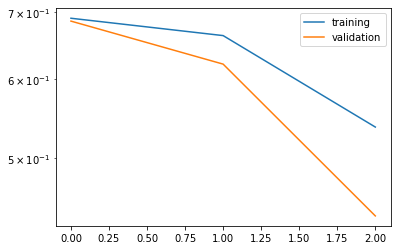

In [27]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [28]:
x_test = f2.get('X')
y_test = f2.get('y')

In [29]:
ss = np.sum(x_test, axis=(1,2)).reshape((x_test.shape[0],1,1,3))

In [30]:
x_test.shape

(10000, 125, 125, 3)

In [31]:
x_test = x_test / np.sum(x_test, axis=(1,2)).reshape((x_test.shape[0],1,1,3))

/tmp/ipykernel_585443/2775091610.py:1: RuntimeWarning: invalid value encountered in divide
  x_test = x_test / np.sum(x_test, axis=(1,2)).reshape((x_test.shape[0],1,1,3))


In [32]:
def mae(x):
    pred = model.predict(x)
    return np.mean(np.abs(x - pred)**2)

def recon_acc(x):
    return 1 - mae(x)

In [33]:
#zerrooo = recon_acc(x_test[:2000]+1)
zerrooo = recon_acc(x_val_zeros)
#one = recon_acc(x_test[8000:10000]+1)

In [34]:
print(zerrooo)

0.8742114901542664


In [35]:
print(np.median(zerrooo))
bins = np.histogram(np.hstack((zerrooo, one)), bins=100)[1]
#print(bins)
bins = np.arange(0.999995,0.9999955,0.00000005)
plt.hist(zerrooo, histtype='step', label="zero",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(one))
plt.hist(one, histtype='step', label="one",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.xlabel("Reconstruction error")
plt.legend()

0.8742114901542664


NameError: name 'one' is not defined

In [ ]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(zerrooo > T)
    # threes that are predicted three
    num_three_right = np.sum(one < T)
    acc = (num_six_right + num_three_right)/(len(zerrooo) + len(one))
    return acc

Ts = np.linspace(0.999938,0.999939,1000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.xlabel("Anomaly threshold")
plt.ylabel("Acc.")
plt.plot(Ts, accs)  

In [ ]:
model.encoder(x_val_zeros[:100]).numpy()

In [41]:
testimg = model(x_val_zeros[0].reshape((1,125*125*3)))

In [42]:
testimg[testimg>0]

<tf.Tensor: shape=(46875,), dtype=float32, numpy=
array([0.35535502, 0.34691203, 0.3423625 , ..., 0.34961194, 0.342593  ,
       0.34881786], dtype=float32)>

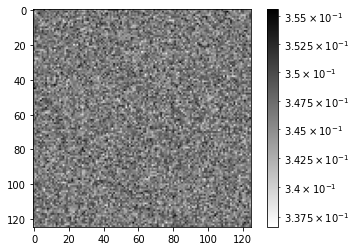

In [43]:
from matplotlib.colors import LogNorm
plt.imshow(testimg.numpy().reshape((1,125,125,3))[0,:,:,0],cmap='binary'x)
plt.colorbar()

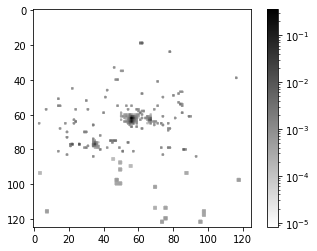

In [44]:
plt.imshow(x_val_zeros[0].reshape((1,125,125,3))[0,:,:,1],cmap='binary',norm=LogNorm())
plt.colorbar()

In [40]:
plt.imshow(x_val_zeros[20,:,:,1]/0.07,cmap='binary')
plt.colorbar()

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed